# Blending Under Uncertainty

## Imports

In [ ]:
# Imports
import sys
if "google.colab" in sys.modules:
    !wget "https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/helper.py"
    import helper
    helper.easy_install()
else:
    sys.path.insert(0, '../')
    import helper
helper.set_plotting_style()
from pyomo.environ import *
import matplotlib.pyplot as plt
import numpy as np

--2024-10-06 16:32:54--  https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6493 (6.3K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]   6.34K  --.-KB/s    in 0s      

2024-10-06 16:32:54 (48.2 MB/s) - ‘helper.py’ saved [6493/6493]

Installing idaes via pip...
idaes was successfully installed
idaes, version 2.6.0


Running idaes get-extensions to install Ipopt, k_aug, and more...
Checking solver versions:
Ipopt 3.13.2 (x86_64-pc-linux-gnu), ASL(20190605)



[K_AUG] 0.1.0, Part of the IDAES PSE framework
Please visit https://idaes.org/ (x86_64-pc-linux-gnu), ASL(20190605)



Couenne 0.5.8 -- an Open-Source solver for Mixed Integer Nonlinear Optimiz

# **Original Problem**
A brewery receives an order for 100 gallons of 4% ABV (alchohol by volume) beer. The brewery has on hand beer A that is 4.5% ABV that cost USD 0.32 per gallon to make, and beer B that is 3.7% ABV and cost USD 0.25 per gallon. Water could also be used as a blending agent at a cost of USD 0.05 per gallon. Find the minimum cost blend that meets the customer requirements.

# **How this project extended the original**
*   +/-10% of Uncertainty for the product demands with equal probabilities
*   +/-20% of Uncertainty for the raw materials' costs with unequal probabilities (Low cost: 10%, Average cost: 70%, High cost: 20%)
*   Setting minimum required water usage for blending = at least 10 gallons

# **Create Model**

In [ ]:
# Create a Pyomo model
model = ConcreteModel()

# Parameters and Sets
abv_A = 0.045
abv_B = 0.037
abv_W = 0.000
abv_target = 0.04

# Product Demands Uncertainty +/-10% (Equal Probability)
demands_scenarios = ['Low Demands','Average Demands','High Demands']
demands= {'Low Demands': 90, 'Average Demands': 100, 'High Demands': 110}
demand_probabilities = {'Low Demands': 1/3, 'Average Demands':1/3, 'High Demands':1/3}

# Cost Uncertainty +/- 20% (Inequal Probability: Low -> 10%, Average -> 70%, High -> 20%)
cost_scenarios = ['Low cost','Avg cost','High cost']
costs_A = {'Low cost': 0.256, 'Avg cost': 0.32, 'High cost':0.384}
costs_B = {'Low cost': 0.20, 'Avg cost': 0.25, 'High cost':0.30}
costs_W = {'Low cost': 0.04, 'Avg cost': 0.05, 'High cost': 0.06}
cost_probabilities = {'Low cost': 0.1, 'Avg cost':0.7, 'High cost':0.2}

# Various Water Policy
min_water_scenarios = ['0 gallon','5 gallons','10 gallons']
min_water_volume = {'0 gallon': 0, '5 gallons': 5, '10 gallons': 10}

# continuous modeling

Optimal Volume of Beer A: 83.75 gallons
Optimal Volume of Beer B: 6.25 gallons
Optimal Volume of Water: 10.00 gallons
Expected Total Cost: 28.86 USD
Standard Deviation of Total Cost: 5.37 USD


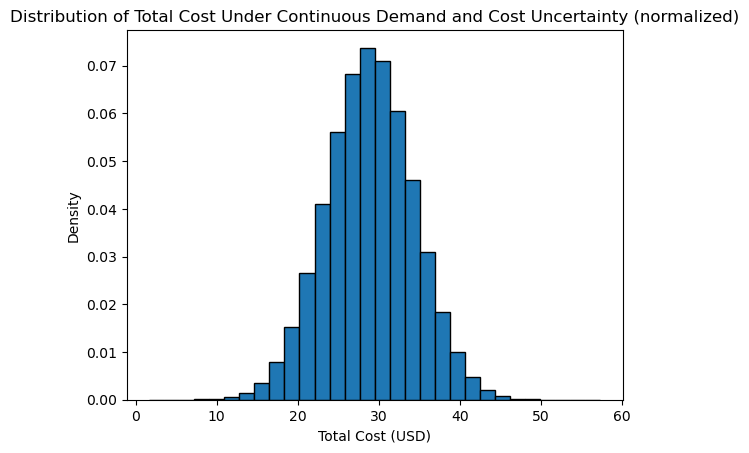

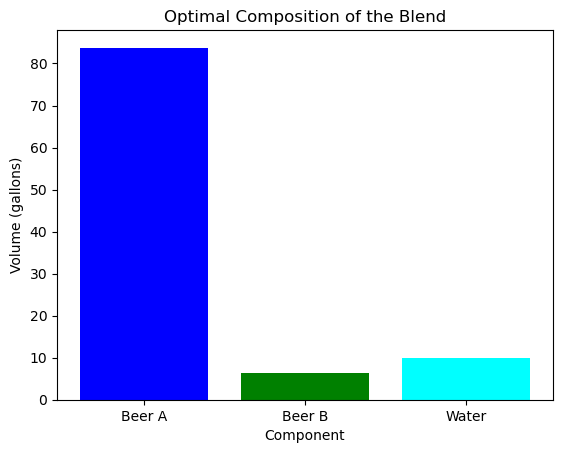

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pyomo.environ import *
from scipy.stats import norm

# creating a Pyomo model
model = ConcreteModel()

# parameters for ABV
abv_A = 0.045
abv_B = 0.037
abv_W = 0.000
abv_target = 0.04

# product demand and cost uncertainty as continuous distributions
mean_demand = 100
std_dev_demand = 10
mean_cost_A = 0.32
std_dev_cost_A = 0.064
mean_cost_B = 0.25
std_dev_cost_B = 0.05
mean_cost_W = 0.05
std_dev_cost_W = 0.01

# generating continuous random demands and costs for Monte Carlo simulation
num_scenarios = 10000000
demands = norm.rvs(loc=mean_demand, scale=std_dev_demand, size=num_scenarios)
costs_A = norm.rvs(loc=mean_cost_A, scale=std_dev_cost_A, size=num_scenarios)
costs_B = norm.rvs(loc=mean_cost_B, scale=std_dev_cost_B, size=num_scenarios)
costs_W = norm.rvs(loc=mean_cost_W, scale=std_dev_cost_W, size=num_scenarios)

# decision variables (note: decisions must be the same across scenarios)
model.x_A = Var(domain=NonNegativeReals)
model.x_B = Var(domain=NonNegativeReals)
model.x_W = Var(domain=NonNegativeReals)

# objective function: minimize the expected cost
def Objective_rule(model):
    return sum((costs_A[i] * model.x_A + costs_B[i] * model.x_B + costs_W[i] * model.x_W) / num_scenarios for i in range(num_scenarios))
model.Obj = Objective(rule=Objective_rule, sense=minimize)

# constraints
# volume constraint (decision made before knowing exact demand)
def Volume_rule(model):
    return model.x_A + model.x_B + model.x_W >= mean_demand
model.Volume = Constraint(rule=Volume_rule)

# ABV constraint
def Abv_rule(model):
    return abv_target == (abv_A * model.x_A + abv_B * model.x_B + abv_W * model.x_W) / (model.x_A + model.x_B + model.x_W)
model.Abv = Constraint(rule=Abv_rule)

# minimum water constraint
def Min_Water_rule(model):
    return model.x_W >= 10
model.Min_Water = Constraint(rule=Min_Water_rule)

# solving the problem
solver = SolverFactory("ipopt")
solver.solve(model)

# extracting results
x_A_value = value(model.x_A)
x_B_value = value(model.x_B)
x_W_value = value(model.x_W)

# presenting optimal values for volume of ingredients
print(f"Optimal Volume of Beer A: {x_A_value:.2f} gallons")
print(f"Optimal Volume of Beer B: {x_B_value:.2f} gallons")
print(f"Optimal Volume of Water: {x_W_value:.2f} gallons")

# running Monte Carlo simulation to evaluate the cost under different scenarios
total_costs = []
for i in range(num_scenarios):
    cost = costs_A[i] * x_A_value + costs_B[i] * x_B_value + costs_W[i] * x_W_value
    total_costs.append(cost)

# calculating and printing expected cost and standard deviation
expected_cost = np.mean(total_costs)
std_dev_cost = np.std(total_costs)
print(f"Expected Total Cost: {expected_cost:.2f} USD")
print(f"Standard Deviation of Total Cost: {std_dev_cost:.2f} USD")

# visualizing the cost distribution (normalized)
plt.hist(total_costs, bins=30, density=True, edgecolor='black')
plt.xlabel('Total Cost (USD)')
plt.ylabel('Density')
plt.title('Distribution of Total Cost Under Continuous Demand and Cost Uncertainty (normalized)')
plt.show()

# visualizing the optimal composition
components = ['Beer A', 'Beer B', 'Water']
volumes = [x_A_value, x_B_value, x_W_value]

plt.bar(components, volumes, color=['blue', 'green', 'aqua'])
plt.xlabel('Component')
plt.ylabel('Volume (gallons)')
plt.title('Optimal Composition of the Blend')
plt.show()

For demands uncertainty scenarios, the index is *c* = 1,2,3. And the costs uncertainty scenarios index is *d* = 1,2,3.
# **With extension, the problem is formed as:**
Will add some equations (Objective, uncertainty, and constraints) later

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


Total Cost: 86.42587506368064
------------------------------------------------------
Include Water at least: 0 gallon
Scenario (Low Demands, Low cost):
  A: 33.8 gallons
  B: 56.2 gallons
  W: 0.0 gallons
  Total Volume: 90.0 gallons
  Total Cost: 19.890
Scenario (Low Demands, Avg cost):
  A: 33.8 gallons
  B: 56.2 gallons
  W: 0.0 gallons
  Total Volume: 90.0 gallons
  Total Cost: 24.863
Scenario (Low Demands, High cost):
  A: 33.8 gallons
  B: 56.2 gallons
  W: 0.0 gallons
  Total Volume: 90.0 gallons
  Total Cost: 29.835


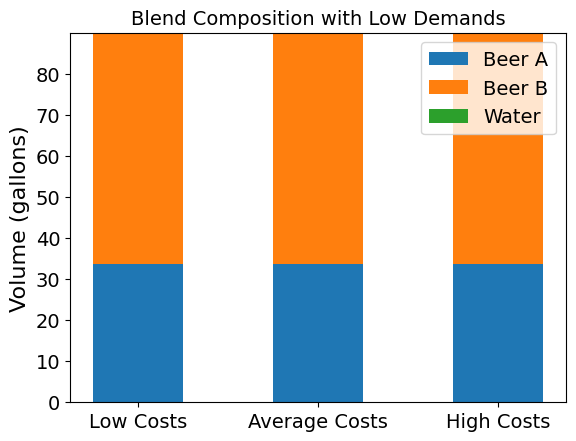

Scenario (Average Demands, Low cost):
  A: 37.5 gallons
  B: 62.5 gallons
  W: 0.0 gallons
  Total Volume: 100.0 gallons
  Total Cost: 22.100
Scenario (Average Demands, Avg cost):
  A: 37.5 gallons
  B: 62.5 gallons
  W: 0.0 gallons
  Total Volume: 100.0 gallons
  Total Cost: 27.625
Scenario (Average Demands, High cost):
  A: 37.5 gallons
  B: 62.5 gallons
  W: 0.0 gallons
  Total Volume: 100.0 gallons
  Total Cost: 33.150


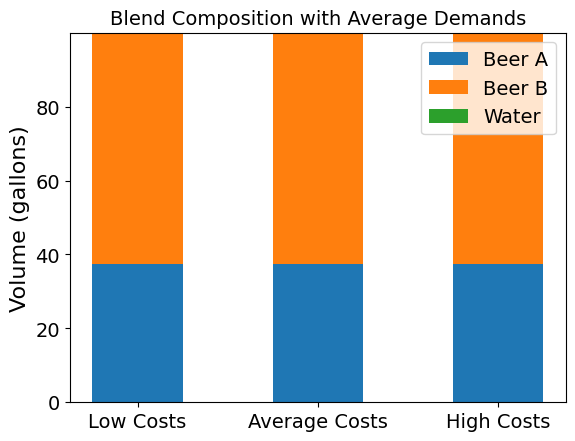

Scenario (High Demands, Low cost):
  A: 41.3 gallons
  B: 68.7 gallons
  W: 0.0 gallons
  Total Volume: 110.0 gallons
  Total Cost: 24.310
Scenario (High Demands, Avg cost):
  A: 41.3 gallons
  B: 68.7 gallons
  W: 0.0 gallons
  Total Volume: 110.0 gallons
  Total Cost: 30.388
Scenario (High Demands, High cost):
  A: 41.3 gallons
  B: 68.7 gallons
  W: 0.0 gallons
  Total Volume: 110.0 gallons
  Total Cost: 36.465


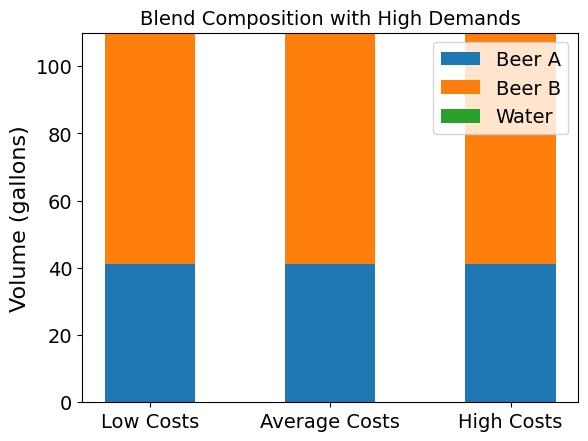

------------------------------------------------------
------------------------------------------------------
Include Water at least: 5 gallons
Scenario (Low Demands, Low cost):
  A: 56.9 gallons
  B: 28.1 gallons
  W: 5.0 gallons
  Total Volume: 90.0 gallons
  Total Cost: 20.385
Scenario (Low Demands, Avg cost):
  A: 56.9 gallons
  B: 28.1 gallons
  W: 5.0 gallons
  Total Volume: 90.0 gallons
  Total Cost: 25.481
Scenario (Low Demands, High cost):
  A: 56.9 gallons
  B: 28.1 gallons
  W: 5.0 gallons
  Total Volume: 90.0 gallons
  Total Cost: 30.578


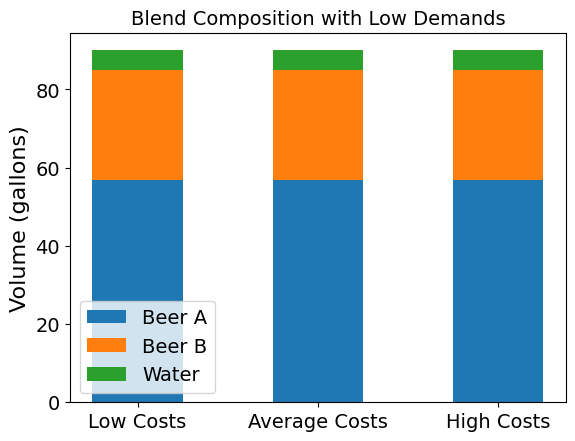

Scenario (Average Demands, Low cost):
  A: 60.6 gallons
  B: 34.4 gallons
  W: 5.0 gallons
  Total Volume: 100.0 gallons
  Total Cost: 22.595
Scenario (Average Demands, Avg cost):
  A: 60.6 gallons
  B: 34.4 gallons
  W: 5.0 gallons
  Total Volume: 100.0 gallons
  Total Cost: 28.244
Scenario (Average Demands, High cost):
  A: 60.6 gallons
  B: 34.4 gallons
  W: 5.0 gallons
  Total Volume: 100.0 gallons
  Total Cost: 33.893


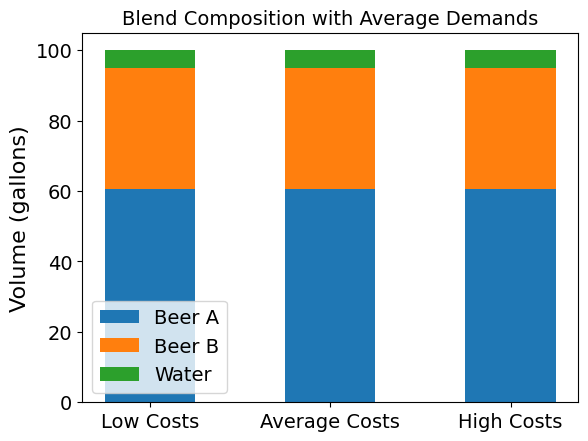

Scenario (High Demands, Low cost):
  A: 64.4 gallons
  B: 40.6 gallons
  W: 5.0 gallons
  Total Volume: 110.0 gallons
  Total Cost: 24.805
Scenario (High Demands, Avg cost):
  A: 64.4 gallons
  B: 40.6 gallons
  W: 5.0 gallons
  Total Volume: 110.0 gallons
  Total Cost: 31.006
Scenario (High Demands, High cost):
  A: 64.4 gallons
  B: 40.6 gallons
  W: 5.0 gallons
  Total Volume: 110.0 gallons
  Total Cost: 37.208


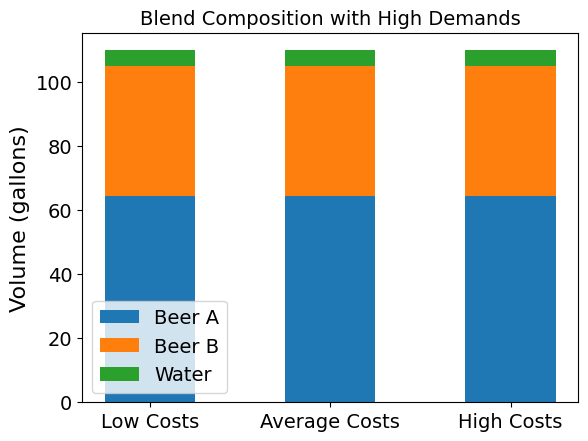

------------------------------------------------------
------------------------------------------------------
Include Water at least: 10 gallons
Scenario (Low Demands, Low cost):
  A: 80.0 gallons
  B: 0.0 gallons
  W: 10.0 gallons
  Total Volume: 90.0 gallons
  Total Cost: 20.880
Scenario (Low Demands, Avg cost):
  A: 80.0 gallons
  B: 0.0 gallons
  W: 10.0 gallons
  Total Volume: 90.0 gallons
  Total Cost: 26.100
Scenario (Low Demands, High cost):
  A: 80.0 gallons
  B: 0.0 gallons
  W: 10.0 gallons
  Total Volume: 90.0 gallons
  Total Cost: 31.320


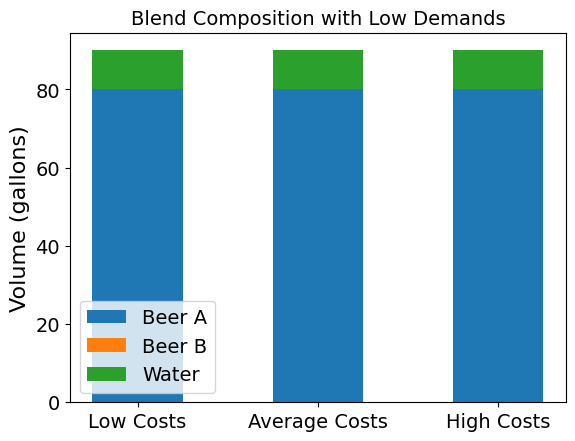

Scenario (Average Demands, Low cost):
  A: 83.8 gallons
  B: 6.2 gallons
  W: 10.0 gallons
  Total Volume: 100.0 gallons
  Total Cost: 23.090
Scenario (Average Demands, Avg cost):
  A: 83.7 gallons
  B: 6.3 gallons
  W: 10.0 gallons
  Total Volume: 100.0 gallons
  Total Cost: 28.862
Scenario (Average Demands, High cost):
  A: 83.8 gallons
  B: 6.2 gallons
  W: 10.0 gallons
  Total Volume: 100.0 gallons
  Total Cost: 34.635


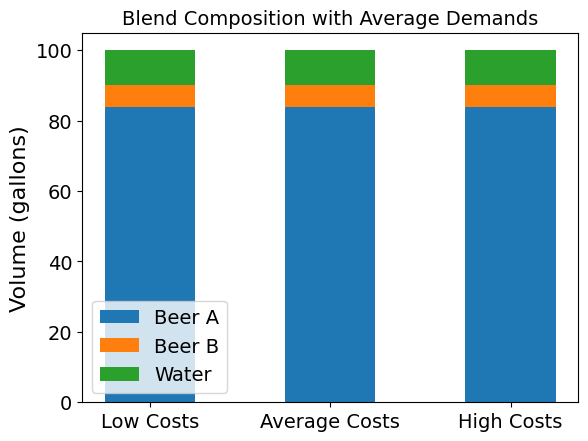

Scenario (High Demands, Low cost):
  A: 87.5 gallons
  B: 12.5 gallons
  W: 10.0 gallons
  Total Volume: 110.0 gallons
  Total Cost: 25.300
Scenario (High Demands, Avg cost):
  A: 87.5 gallons
  B: 12.5 gallons
  W: 10.0 gallons
  Total Volume: 110.0 gallons
  Total Cost: 31.625
Scenario (High Demands, High cost):
  A: 87.5 gallons
  B: 12.5 gallons
  W: 10.0 gallons
  Total Volume: 110.0 gallons
  Total Cost: 37.950


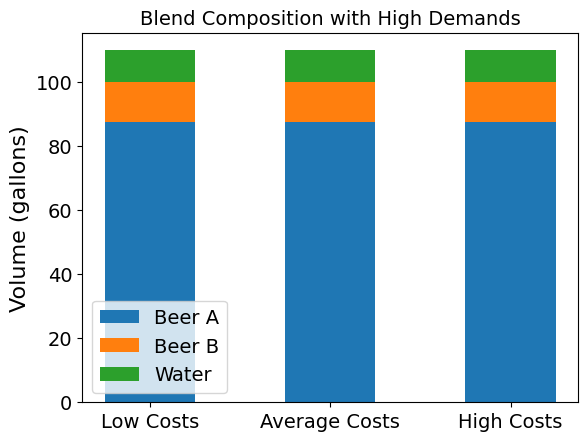

------------------------------------------------------


In [ ]:
# Variables
model.x_A = Var(demands_scenarios, cost_scenarios, min_water_scenarios, domain=NonNegativeReals)
model.x_B = Var(demands_scenarios, cost_scenarios, min_water_scenarios, domain=NonNegativeReals)
model.x_W = Var(demands_scenarios, cost_scenarios, min_water_scenarios, domain=NonNegativeReals)

# Objective
def Objective_rule(model):
  return sum(demand_probabilities[d]*cost_probabilities[c]*(costs_A[c]*model.x_A[d,c,w] + costs_B[c]*model.x_B[d,c,w] + costs_W[c]*model.x_W[d,c,w]) for d in demands_scenarios for c in cost_scenarios for w in min_water_scenarios)
model.Obj = Objective(rule=Objective_rule, sense=minimize)

# Constraints
def min_Water_rule(model, d, c, w):
  return model.x_W[d, c, w] >= min_water_volume[w]
model.min_Water = Constraint(demands_scenarios, cost_scenarios, min_water_scenarios, rule=min_Water_rule)

def Volume_rule(model, d, c, w):
  return demands[d]==model.x_A[d,c,w]+model.x_B[d,c,w]+model.x_W[d,c,w]
model.Volume = Constraint(demands_scenarios, cost_scenarios, min_water_scenarios, rule=Volume_rule)

def Abv_rule(model, d, c, w):
  return abv_target == (abv_A * model.x_A[d,c,w] + abv_B*model.x_B[d,c,w]+abv_W*model.x_W[d,c,w])/(model.x_A[d,c,w]+model.x_B[d,c,w]+model.x_W[d,c,w])
model.Abv = Constraint(demands_scenarios, cost_scenarios, min_water_scenarios, rule=Abv_rule)


# Solve problem
solver = SolverFactory("ipopt")
solver.solve(model)
cost = value(model.Obj)
print(f"Total Cost: {cost}")
min_cost_results = {}

# print
for w in min_water_scenarios:
  print(f"------------------------------------------------------")
  print(f"Include Water at least: {w}")
  for d in demands_scenarios:
    # Save results
    beer_A_volumes = []
    beer_B_volumes = []
    water_volumes = []
    for c in cost_scenarios:
      beer_A_volumes.append(value(model.x_A[d,c,w]))
      beer_B_volumes.append(value(model.x_B[d,c,w]))
      water_volumes.append(value(model.x_W[d,c,w]))

      print(f"Scenario ({d}, {c}):")
      print(f"  A: {value(model.x_A[d,c,w]):.1f} gallons")
      print(f"  B: {value(model.x_B[d,c,w]):.1f} gallons")
      print(f"  W: {value(model.x_W[d,c,w]):.1f} gallons")
      print(f"  Total Volume: {value(model.Volume[d,c,w]):.1f} gallons")
      print(f"  Total Cost: {value(model.x_A[d,c,w]*costs_A[c] + model.x_B[d,c,w]*costs_B[c] + model.x_W[d,c,w]*costs_W[c]):.3f}")

    scenarios = ['Low Costs','Average Costs','High Costs']
    ind = np.arange(len(scenarios))
    width = 0.5

    p1 = plt.bar(ind, beer_A_volumes, width, label='Beer A')
    p2 = plt.bar(ind, beer_B_volumes, width, bottom=beer_A_volumes, label='Beer B')
    p3 = plt.bar(ind, water_volumes, width, bottom=np.array(beer_A_volumes)+np.array(beer_B_volumes), label='Water')

    plt.ylabel('Volume (gallons)')
    plt.title('Blend Composition with ' + d)
    plt.xticks(ind, scenarios)
    plt.legend()

    plt.show()
  print(f"------------------------------------------------------")

# Mathematical Formulation of the Blending Problem

The blending problem aims to determine the optimal volumes of Beer A, Beer B, and Water required to produce a target volume of beer with a specific Alcohol By Volume (ABV) while minimizing the cost.

### Objective Function
The objective is to minimize the expected cost of production. The cost is influenced by uncertainty in the cost of ingredients and is expressed as follows:

$$
\text{Minimize } E[\text{Cost}] = \frac{1}{N} \sum_{i=1}^N \left( C_{A,i} x_A + C_{B,i} x_B + C_{W,i} x_W \right)
$$

Where:
- $E[\text{Cost}]$ is the expected cost.
- $N$ is the number of scenarios.
- $C_{A,i}, C_{B,i}, C_{W,i}$ are the costs of Beer A, Beer B, and Water in scenario $i$.
- $x_A, x_B, x_W$ are the decision variables representing the volumes of Beer A, Beer B, and Water respectively.

### Constraints
1. **Volume Constraint**:
   The total volume of Beer A, Beer B, and Water must be at least equal to the mean demand:
   $$
   x_A + x_B + x_W \geq D
   $$
   Where $D$ is the mean demand.

2. **ABV Constraint**:
   The final blend must have an alcohol content of 4% ABV. This constraint is expressed as:
   $$
   ABV_{target} = \frac{ABV_A x_A + ABV_B x_B + ABV_W x_W}{x_A + x_B + x_W}
   $$
   Where:
   - $ABV_{target}$ is the target ABV (4%).
   - $ABV_A, ABV_B, ABV_W$ are the ABV values for Beer A, Beer B, and Water respectively.

3. **Minimum Water Constraint**:
   There must be at least 10 gallons of Water in the blend:
   $$
   x_W \geq 10
   $$

### Monte Carlo Simulation
The Monte Carlo simulation is used to evaluate the cost under different scenarios of cost and demand uncertainty. By generating random values for the costs and demands based on given distributions, we can calculate the expected value and standard deviation of the total cost.

- **Expected Cost**: The average cost across all simulated scenarios.
- **Standard Deviation of Cost**: A measure of the variability in cost due to uncertainties in demand and ingredient prices.

The results are visualized to understand the distribution of the cost and the optimal blend composition.

### Results
- **Optimal Volume of Beer A**: 83.75 gallons
- **Optimal Volume of Beer B**: 6.25 gallons
- **Optimal Volume of Water**: 10.00 gallons
- **Expected Total Cost**: 28.87 USD
- **Standard Deviation of Total Cost**: 5.38 USD
